# Machine Learning project
By Mattia Barbiere

In [460]:
%config InlineBackend.figure_formats = ['svg'] #To improve graph resolution
import sys
import sklearn
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

## The Data

Before we try to fit the models we should first see what kind of data we are dealing with. This helps us to get a feel for the data so we can already start understanding where our models are a good choice or not.

In [461]:
df = pd.read_csv("mldata_0003151393.csv", index_col=0)
X = df[df.columns[1:]]
y = df['label']

In [462]:
df.head(10)

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20
0,1,-2.887351,2.368955,-0.625925,-3.978334,-0.326955,4.055608,-0.235264,0.273827,-0.517484,...,1.510891,-0.111374,0.940897,-3.955810,-0.363500,0.199346,0.461904,-0.126972,1.626261,-0.182263
1,3,1.334865,-1.751757,-0.578244,-2.852914,-0.046243,-0.404612,4.838986,2.054794,0.641435,...,-1.172510,-0.015095,0.175453,-2.446950,-0.718050,0.596897,0.170454,-1.004904,2.982466,-3.522866
2,0,-1.073810,3.398483,-1.099216,1.529714,1.319205,4.183233,-4.627822,0.452511,3.557216,...,0.821012,6.678114,-0.540001,1.582700,0.466075,-2.284209,0.133034,0.216640,2.448328,2.277177
3,3,-1.459105,0.604342,-0.052011,0.196076,2.174851,-0.732217,-1.997095,2.443736,3.655130,...,0.491459,-0.112123,1.388338,-2.690753,0.997441,-0.957406,-1.423567,-0.276991,0.858894,-0.212745
4,2,0.508266,3.532480,-0.196915,-3.370030,0.177465,0.025390,2.840482,1.251280,-3.536680,...,0.758948,-5.192279,-0.341884,-2.078780,1.978526,1.532484,2.001019,-1.013421,-1.295467,-1.002012
5,4,-0.316656,-0.922855,1.447635,1.699483,0.022101,0.473463,-0.126300,0.966990,1.545700,...,-0.574484,2.309736,-1.206329,0.574633,-0.158552,-1.874306,0.576478,-0.918869,-0.961063,0.828915
6,3,-0.350357,-0.280938,1.572685,0.922978,2.159589,-1.828143,1.953110,1.780278,0.755949,...,-0.297084,1.999719,1.578167,-0.109991,0.199291,-2.984111,0.158336,-1.480244,-0.604203,-1.328385
7,2,1.512664,2.661731,-1.997446,-0.114986,-0.558272,-0.272194,2.245315,2.066404,1.031266,...,-1.191092,-4.413065,1.049424,-2.668520,-0.566365,0.140097,1.048035,-0.162599,-2.040033,-0.893740
8,2,-1.331660,0.894030,0.167612,-2.500779,2.216463,5.035682,-5.196242,0.905760,2.859414,...,-0.008510,4.528739,0.215946,0.495931,-1.454981,0.590947,-0.027441,0.839361,2.616551,3.506210
9,3,0.437816,-0.601652,-0.031859,-1.010379,-1.492245,1.222452,3.299241,0.504061,-0.439967,...,-0.762156,-3.027410,-1.525858,-2.826487,1.820201,1.583277,-0.455038,-1.004994,-0.963731,-2.737519


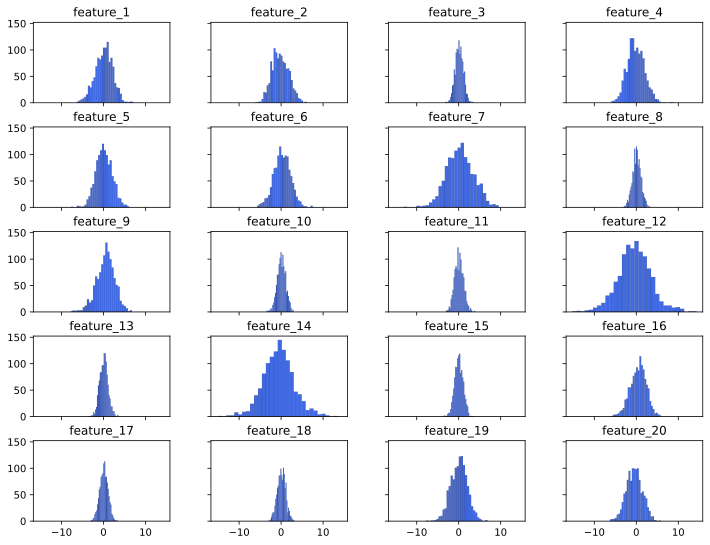

In [463]:
#Histogram for every feature all in the same scale
X.hist(bins=30, 
       figsize=(12,9), 
        color="royalblue",
        ec="black", 
        lw=0.1, 
        grid=False, 
        sharex='col', 
        sharey='row')
plt.show()


From the graphs above we see that the features were generated probably by a normal distribiution with mean 0. The variance amoung the features however is different. We see that `feature_17` has a much smaller variance compared to `feature_1`. This is exactly what we see when we caluculate the means and standerd deviations of all the features. 

In [464]:
#Descriptive aspects of the data
print("Number of missing values: ", df.isna().sum().sum())
X.describe().T

Number of missing values:  0


,count,mean,std,min,25%,50%,75%,max
feature_1,1200.0,0.101575,2.078299,-6.378028,-1.287177,0.221206,1.564032,7.044498
feature_2,1200.0,-0.166710,1.981571,-6.266420,-1.594085,-0.263605,1.224438,6.042347
feature_3,1200.0,0.132981,0.967590,-3.145218,-0.512257,0.125932,0.793849,3.520966
feature_4,1200.0,-0.087112,2.053683,-5.960159,-1.482476,-0.149005,1.324697,8.877270
feature_5,1200.0,0.125522,1.938720,-7.697257,-1.158171,0.069604,1.465483,6.083652
feature_6,1200.0,0.253446,2.006632,-5.721129,-1.060267,0.230359,1.581070,7.492904
feature_7,1200.0,0.313112,3.200007,-13.068389,-1.906664,0.277519,2.503021,9.531424
feature_8,1200.0,0.107007,1.010086,-3.038071,-0.543744,0.112021,0.779632,3.329917
feature_9,1200.0,0.488320,2.187284,-7.828465,-0.844002,0.640040,1.920727,6.772510
feature_10,1200.0,0.093529,1.012772,-3.620827,-0.581886,0.086866,0.794594,2.951366


Total average correlation:  0.05599543199968648
Average correlation for each feature: 
 feature_1     0.098121
feature_2    -0.004305
feature_3     0.041617
feature_4     0.035590
feature_5     0.072204
feature_6     0.111855
feature_7    -0.063248
feature_8     0.046115
feature_9     0.012310
feature_10    0.051752
feature_11    0.045150
feature_12    0.135671
feature_13    0.059532
feature_14    0.138615
feature_15    0.058017
feature_16    0.025011
feature_17    0.043796
feature_18    0.050822
feature_19    0.075835
feature_20    0.085448
dtype: float64


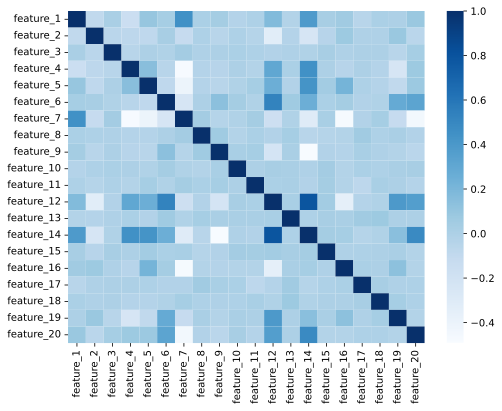

In [465]:
#Correlation amoung features
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), cmap='Blues')
print("Total average correlation: ", X.corr().stack().mean())
print("Average correlation for each feature: \n", X.corr().mean())
plt.show()

By looking at the heatmap above we can visually see which features tend to be more correlated (positivley or negatively) with the other genes. From this we can choose for example features 12,14 and 20 to be represented in the next scatter matrix.

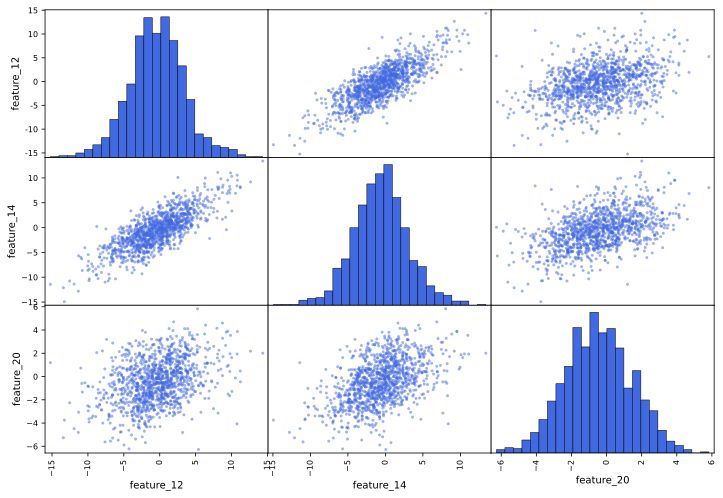

In [466]:
from pandas.plotting import scatter_matrix

#Displaying the scatter matrix with the chosen features
feats = ["feature_12", "feature_14", "feature_20"]
scatter_matrix(df[feats], figsize=(12, 8), c="royalblue", 
               hist_kwds={'bins': 25, 'color': "royalblue", 'ec': 'black', 'lw': 0.5})
plt.show()


It is quite surprising the correlation between feature 12 and 14. This is probably chance as our data is generated randomly. Coincidently the features we chose are also the features with the highest standard deviation. This could explain why they are slightly correlated with each other since their histograms are all quite spread out compared to the other features. 

## Defining and training the models

We can now start working with the models. We have 5 different kinds of labels in our dataset. Our objective is to fit logistic regression and K nearest neighbor so that we can test their performance and see which one is the best model. Before training we should check is that we have sufficient examples for each label.

In [467]:
# Percentage of examples for each label
round((y.value_counts().sort_index()/df.shape[0]) * 100, 2)

0    20.33
1    18.58
2    20.50
3    20.50
4    20.08
Name: label, dtype: float64

Overall the examples for each label are very balanced. This a a good sign as we have sufficent examples to train our classifiers. This also removes a layer of complexity in our models.

The next step are the actual models. As always we start of splitting the data into train and test sets in order to test the models on new data later on.

In [468]:
from sklearn.model_selection import train_test_split

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To define the models we start of with a pipeline. This is a very simple pipeline as there is no imputing or transformation to do with the data. Notice that we add `('scaler', StandardScaler())` to the pipeline. As we show in the histograms above our data already has a gaussian distribiution with mean close to 0 and standard deviation between 1 and 3. For this reason there might be no reason to scale the data, however we add it anyway and we will run Grid Search to see where accuracy improves or not by applying the removing the scaler.

In [469]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Making the one pipeline for each model
#-------K Nearest Neighbor-------
pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('KNN_model', KNeighborsClassifier())
    ])

#-------Logistic Regression-------
pipe_logi = Pipeline([
        ('scaler', StandardScaler()),
        ('logi_model', LogisticRegression(random_state=0))
    ])

#Fitting both pipelines
pipe_logi.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)

print(pipe_logi,"\n", pipe_knn)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logi_model', LogisticRegression(random_state=0))]) 
 Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN_model', KNeighborsClassifier())])


## Performance Measures

The main objective of this project was comparing K Nearest Neighbor to Logistic Regression. In order to do so we need to evaluate the performance of the two models in such a way we can compare the outcomes.
As performance measures I chose:
* `pipeline.score(X_test, y_test)`: This simply evaluates the model with the test data and comparing it to the true labels to get an accuracy of the model.

* `cross_val_score().mean()`: This will give us a score while eliminating any bias we have in our train-test split. We then take the mean over all the k folds.

* `Confusion Matrix`: With the confusion matrix will be able to understand where are models are misclassifying the labels.

In [470]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import KFold

#Number of folds for cross validation
kfold=10
kfold = KFold(shuffle=True, n_splits=5, random_state=42)

#A function which returns all the permormance measures we want
def permormance(pipeline: sklearn.pipeline.Pipeline, title: str, when: str):
      """
      Given as input a pipeline (with a model) and a title it returns some performance measures of that pipeline
      """
      #Changing text based on the input "when"
      if when == "before":
            print(title + " before Grid Search:")
      elif when == "after":
            print(title + " after Grid Search:")
      
      #Displaying the mean CV score
      print(" Mean CV score: ", 
            f"{round(cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy').mean() * 100,2)}%")
      
      #Displaying the accuracy
      print(" Accuracy: ", f"{round(pipeline.score(X_test, y_test) * 100,2)}%")

      #Displaying the average (Macro) precision 
      print(" Average macro precision: ", 
            f"{round(precision_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)}%")
      
      #Displaying the average (Macro) recall
      print(" Average macro recall: ", 
            f"{round(recall_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)}%")
      
      #Displaying the average (Macro) F1 score
      print(" Average macro F1 score: ", 
            f"{round(f1_score(y_test, pipeline.predict(X_test), average='macro') * 100,2)}%")
      
      #Plotting the heatmap to illustrate the confusion matrix
      plt.figure(figsize = (9,4), dpi=100)
      sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)),
                  cmap = 'Blues',
                  annot = True)
      plt.xlabel('Predicted Labels')
      plt.ylabel('True Labels')
      plt.title("Confusion matrix:")
      plt.show()


K Nearest Neighbor before Grid Search:
 Mean CV score:  63.25%
 Accuracy:  60.83%
 Average macro precision:  60.9%
 Average macro recall:  61.34%
 Average macro F1 score:  60.94%


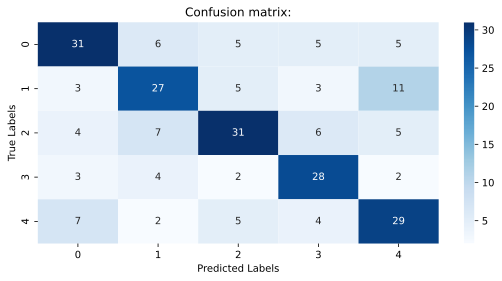

Logistic Regression before Grid Search:
 Mean CV score:  46.42%
 Accuracy:  45.42%
 Average macro precision:  44.48%
 Average macro recall:  45.79%
 Average macro F1 score:  43.51%


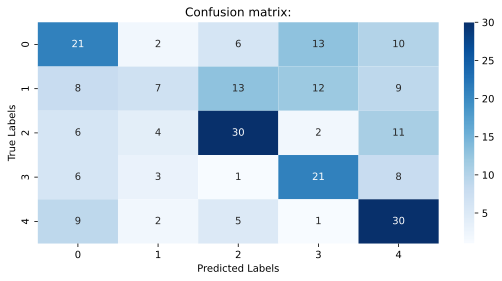

In [471]:
#Performance measures before Grid Search
#-------K Nearest Neighbor-------
permormance(pipe_knn, "K Nearest Neighbor", "before")

#-------Logistic Regression-------
permormance(pipe_logi, "Logistic Regression", "before")

Can we improve our models by varying our hyperparameters? To check this we will run Grid Search on the model and see which combination of hyperparameters is the best.
We can start with the Grid Search for K Nearest Neighbor. These are the parameters we are going to use:
* __Scaler__ : I chose the most widly used scalers: `StandardScaler()` and `MinMaxScaler()`. I also gave it the option of not choosing any scaler.

* __Algorithm__ : The sklearn library lows `KNeighborsClassifier()` to have different algorithms, I want to find the best for our data

* __Leaf Size__ : This is the size of the leaf nodes if you use `'ball_tree'` or `'kd_tree'` algorithms. This obviously comes with an increase in memory usage

* __Number of neighbors__ : This tells us how many neighbors to take into consideration when classifying a data point

* __p__ : This is the parameter that defines the distance measure, in my case I chose 1 (L1 norm) or 2 (L2 norm)

* __Weights__ : When taking the majority vote to decide the label of a data point this parameter tell us if we should consider every vote equally or if we should have the weight inversly proportional to the distance.

In [472]:
from sklearn.model_selection import GridSearchCV

#Grid search for K Nearest Neighbors
g_param_knn = {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'KNN_model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'KNN_model__leaf_size': [1, 5],
                'KNN_model__n_neighbors': [5, 6, 7, 8],
                'KNN_model__p': [1, 2],
                'KNN_model__weights': ['uniform', 'distance']}
g_knn = GridSearchCV(pipe_knn, g_param_knn, cv=kfold, scoring='accuracy', n_jobs=-1)
g_knn.fit(X_train, y_train)

#Results of Grid Search
print("Best score from Grid Search for KNN: ", f"{round(g_knn.best_score_ * 100, 2)}%")
print("Best parameters given by Grid Search for K Nearest Neighbor: ")
g_knn.best_params_


Best score from Grid Search for KNN:  70.0%
Best parameters given by Grid Search for K Nearest Neighbor: 


{'KNN_model__algorithm': 'ball_tree',
 'KNN_model__leaf_size': 1,
 'KNN_model__n_neighbors': 7,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance',
 'scaler': None}

We can now fit agian the data using the best hyperparameters we have. This will be used to compare the two models in the conclusion section. 

K Nearest Neighbor after Grid Search:
 Mean CV score:  70.75%
 Accuracy:  75.83%
 Average macro precision:  76.42%
 Average macro recall:  75.65%
 Average macro F1 score:  75.47%


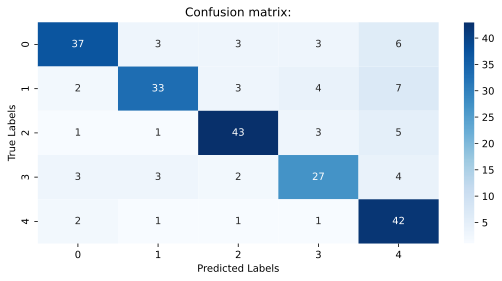

In [473]:
#Setting pipeline to the best estimator given by grid search (as rifit = True by default)
pipe_knn = g_knn.best_estimator_
permormance(pipe_knn, "K Nearest Neighbor", "after")
pipe_knn

When it comes to Logistic Regression I found that there were many more hyperparameters to tune and this lead to a very computaionally intensive Grid Search. For this reason we had to reduce our options of possible parameter values.
I ended up with the following parameters options:

* __Scaler__ : Same as before be choose which scaler (if any) is best for our model.

* __Penalty__ : This choose whether we should use regularization or not. If we choose to use it we can only have l2 regularization as our solvers do not support l1 regularization.

* __C__ : This is the inverse of the regularization term. It is important to tune this parameter however it only has meaning if we use regularization and this is why I make to separate dictionaries for the possible parameter values. The `np.logspace` function is useful to have different values with varying powers of 10.

* __Multi_class__ : As we are performing multiclass classification we need to specify this in the model parameters for the logistic regression. Our options are `multinomial` and `ovr`. The fomer uses the multinomail distribiution to give a probability to each label for every example. The `ovr` on the other hand implements the One vs Rest idea in which the problem is subdivided into 5 binary classification problems.

* __Solver__ : There various solvers we could use for our logistic regression. To norrow our search I will restrict our options only to solvers that can support multinomial loss. Some of these solvers like `saga` and `sag` took many iterations to converge and slowed our Grid search down with little added benefit, for this reason I ommited them from our list.


In [474]:
#Grid search for Logistic Regression
g_param_logi = [{'scaler': [StandardScaler(), MinMaxScaler(), None],
                'logi_model__penalty' : ['l2'],
                'logi_model__C' : np.logspace(-5, 5, 7),
                'logi_model__multi_class': ['multinomial', 'ovr'],
                'logi_model__solver': ['newton-cg', 'lbfgs']
                },
                {'scaler': [StandardScaler(), MinMaxScaler(), None],
                'logi_model__penalty' : [None],
                'logi_model__multi_class': ['multinomial', 'ovr'],
                'logi_model__solver': ['newton-cg', 'lbfgs']
                }]

g_logi = GridSearchCV(pipe_logi, g_param_logi, cv=kfold, scoring='accuracy', n_jobs=-1)
g_logi.fit(X_train, y_train)

#Results of Grid Search
print("Best score from Grid Search: ", f"{round(g_logi.best_score_ * 100, 2)}%")
print("Best parameters given by Grid Search for K Nearest Neighbor: ")
g_logi.best_params_


Best score from Grid Search:  48.33%
Best parameters given by Grid Search for K Nearest Neighbor: 


{'logi_model__C': 0.021544346900318846,
 'logi_model__multi_class': 'multinomial',
 'logi_model__penalty': 'l2',
 'logi_model__solver': 'newton-cg',
 'scaler': None}

Logistic Regression after Grid Search:
 Mean CV score:  47.0%
 Accuracy:  46.67%
 Average macro precision:  46.22%
 Average macro recall:  47.24%
 Average macro F1 score:  44.61%


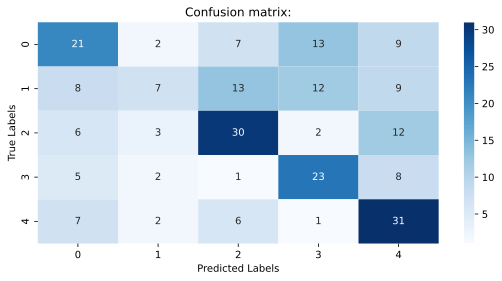

Pipeline(steps=[('scaler', None),
                ('logi_model',
                 LogisticRegression(C=0.021544346900318846,
                                    multi_class='multinomial', random_state=0,
                                    solver='newton-cg'))])

In [482]:
#Setting pipeline to the best estimator given by grid search (as rifit = True by default)
pipe_logi = g_logi.best_estimator_
permormance(pipe_logi, "Logistic Regression", "after")
pipe_logi

## Conclusion

Overall we can easily conclude that K Nearest Neighbor is the superior classification algorithm for this dataset. It achieves an accuracy just above 70% which is not the best but it definitly trumps the Logistic Regression algorithms accuracy of less than 50%.
Below you can find all the parameters of the best K Nearest Neighbor algorithm I found.

In [477]:
g_knn.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', None),
  ('KNN_model',
   KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7,
                        weights='distance'))],
 'verbose': False,
 'scaler': None,
 'KNN_model': KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7,
                      weights='distance'),
 'KNN_model__algorithm': 'ball_tree',
 'KNN_model__leaf_size': 1,
 'KNN_model__metric': 'minkowski',
 'KNN_model__metric_params': None,
 'KNN_model__n_jobs': None,
 'KNN_model__n_neighbors': 7,
 'KNN_model__p': 2,
 'KNN_model__weights': 'distance'}